PianoRoll


In [ ]:
!pip install pypianoroll

In [105]:
import pypianoroll
import glob
import mido
import numpy as np

In [197]:
def midi_to_pianoroll(files_path):

    piano_roll = []
    for file in glob.glob(files_path):
        # track_piano_rolls = []
        track_count = 0
        multitrack = pypianoroll.read(file)
        pianorolls = multitrack.tracks
        multitrack.plot()
        multitrack_for_piano_roll = pypianoroll.Multitrack()
        for track in pianorolls:
            if(track.is_drum == False):
                multitrack_for_piano_roll.append(pypianoroll.StandardTrack(pianoroll=track.pianoroll, program=track_count))
                track_count += 1
        piano_roll.append(multitrack_for_piano_roll.blend())
    
    return piano_roll

In [198]:
def pianoroll_to_midi(piano_rolls, file_path):
    multitrack_out = pypianoroll.Multitrack()
    multitrack_out.append(pypianoroll.StandardTrack(pianoroll=piano_rolls, program=0))
    multitrack_out.write(file_path)


## Example

Пример преобразования midi в piano roll с помощью функции midi_to_pianoroll, описанной выше

c:\Python311\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


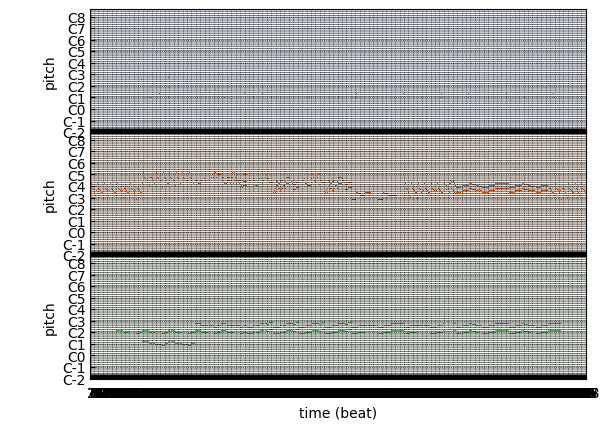

In [199]:
files_path = "input-sounds/genres/test/example.mid"
piano_rolls = midi_to_pianoroll(files_path)

Сохранение и загрузка piano_rolls(Будет нужно для обучения и генерации)

In [201]:
np.save('generated/piano_rolls/classical/piano_rolls.npy', piano_rolls)

In [202]:
loaded_piano_rolls = np.load('generated/piano_rolls/classical/piano_rolls.npy', allow_pickle=True)
print(loaded_piano_rolls)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Преобразование piano_rolls в midi файл

In [207]:
for track_piano_roll, i in zip(loaded_piano_rolls, range(len(loaded_piano_rolls))):
    pianoroll_to_midi(track_piano_roll, "generated/tmp/example_out_" + str(i) + ".mid")

Увеличение темпа (преобразование в piano roll, почти в два раза замедляет midi)

In [208]:
files_path = "generated/tmp/*.mid"
for file, i in zip(glob.glob(files_path), range(len(glob.glob(files_path)))):
    mid = mido.MidiFile(file)

    new_tempo = mido.bpm2tempo(240)
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'set_tempo':
                msg.tempo = new_tempo

    mid.save("generated/tmp/example_out_" + str(i) + ".mid")
